In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
img_count = len(list(data_dir.glob('*/*.jpg')))
print(img_count)

3670


In [4]:
# Rose images
roses = list(data_dir.glob('roses/*'))

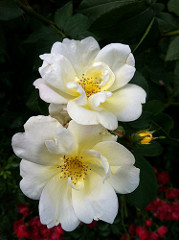

In [5]:
PIL.Image.open(str(roses[0]))

In [6]:
# Tulips images
tulips = list(data_dir.glob('tulips/*'))

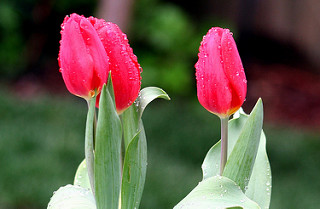

In [7]:
PIL.Image.open(str(tulips[0]))

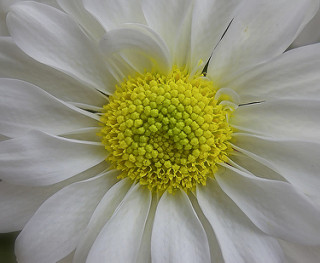

In [8]:
daisy = list(data_dir.glob('daisy/*'))
PIL.Image.open(str(daisy[0]))

## Load data using a Keras Utility

In [9]:
# Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

## Data Visualization

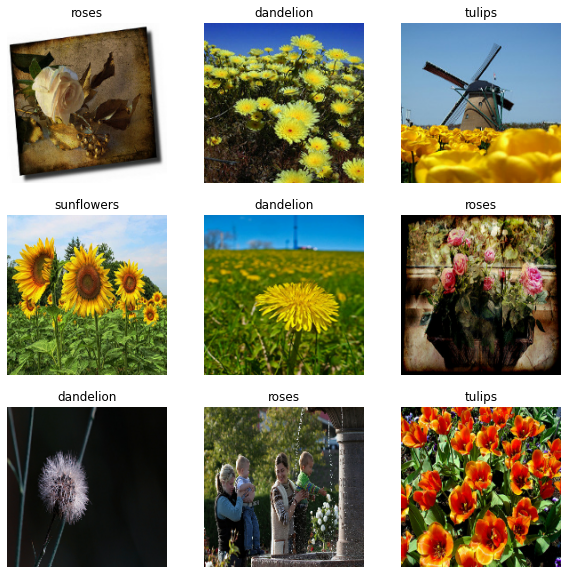

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


## Configure Dataset for performance

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the Data

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


## Create the model

In [18]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

## Compile the Model

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Train the model

In [21]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 21s 223ms/step - loss: 1.3406 - accuracy: 0.4285 - val_loss: 1.1482 - val_accuracy: 0.4877
Epoch 2/10
92/92 [==============================] - 20s 215ms/step - loss: 1.0176 - accuracy: 0.5957 - val_loss: 1.0480 - val_accuracy: 0.5790
Epoch 3/10
92/92 [==============================] - 20s 217ms/step - loss: 0.8499 - accuracy: 0.6747 - val_loss: 0.9113 - val_accuracy: 0.6444
Epoch 4/10
92/92 [==============================] - 20s 218ms/step - loss: 0.6468 - accuracy: 0.7674 - val_loss: 0.8914 - val_accuracy: 0.6553
Epoch 5/10
92/92 [==============================] - 20s 217ms/step - loss: 0.4446 - accuracy: 0.8416 - val_loss: 0.9592 - val_accuracy: 0.6635
Epoch 6/10
92/92 [==============================] - 20s 216ms/step - loss: 0.2654 - accuracy: 0.9145 - val_loss: 1.2716 - val_accuracy: 0.6185
Epoch 7/10
92/92 [==============================] - 20s 217ms/step - loss: 0.1481 - accuracy: 0.9578 - val_loss: 1.2631 - val_accuracy: 0.6499

## Visualize the training results

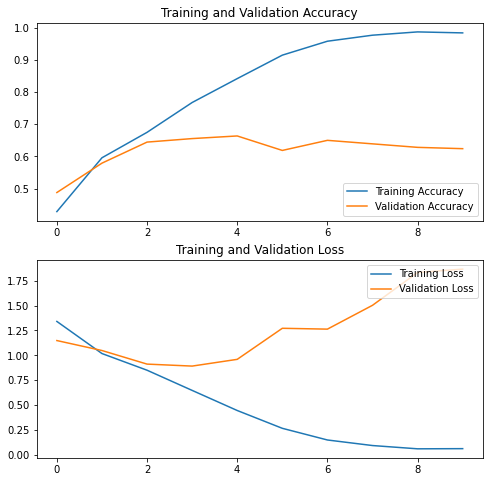

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data Augmentation

In [23]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

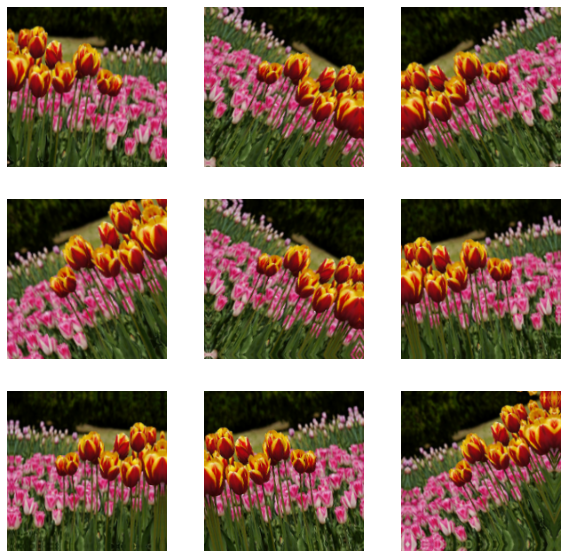

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

## Dropout Training Model

In [25]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [28]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 24s 250ms/step - loss: 1.4387 - accuracy: 0.3866 - val_loss: 1.1903 - val_accuracy: 0.5068
Epoch 2/15
92/92 [==============================] - 23s 250ms/step - loss: 1.1193 - accuracy: 0.5272 - val_loss: 1.1142 - val_accuracy: 0.5395
Epoch 3/15
92/92 [==============================] - 23s 250ms/step - loss: 1.0374 - accuracy: 0.5807 - val_loss: 0.9581 - val_accuracy: 0.6063
Epoch 4/15
92/92 [==============================] - 23s 249ms/step - loss: 0.9502 - accuracy: 0.6240 - val_loss: 0.9311 - val_accuracy: 0.6322
Epoch 5/15
92/92 [==============================] - 23s 252ms/step - loss: 0.8931 - accuracy: 0.6577 - val_loss: 0.8688 - val_accuracy: 0.6594
Epoch 6/15
92/92 [==============================] - 23s 251ms/step - loss: 0.8576 - accuracy: 0.6706 - val_loss: 0.8886 - val_accuracy: 0.6471
Epoch 7/15
92/92 [==============================] - 23s 251ms/step - loss: 0.8124 - accuracy: 0.6935 - val_loss: 0.7989 - val_accuracy: 0.6662

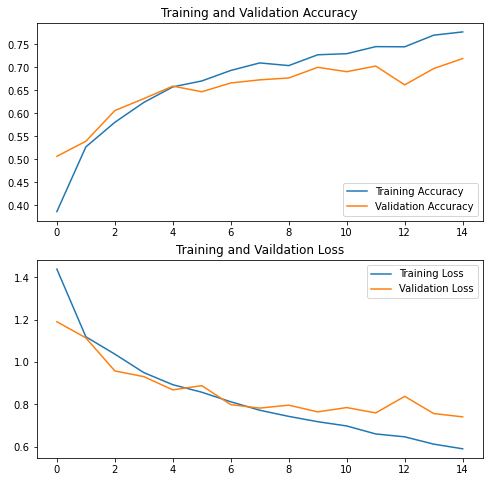

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Vaildation Loss')
plt.show()

## Predicting on new data

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    f'This image most likely belongs to {class_names[np.argmax(score)]} with a {(100 * np.max(score)):.2F} percent confidence'
)

1/1 [==============================] - 0s 78ms/step
This image most likely belongs to sunflowers with a 90.43 percent confidence
